In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import scipy.ndimage
from astropy import units as u

from scalessim.DFT import *
from scalessim.binning import *
from scalessim.phasescreen import *
from scalessim.pupil import *
from scalessim.io import *
from scalessim.focal_plane import *
from scalessim.targs import *
from scalessim.base import *
from scalessim.helpers import *

## Configure your H2RG

Load in h2rg configuration file 

In [2]:
import configparser
from detector import nghxrg as ng

config = configparser.ConfigParser()
config.read('h2rg.ini')

arg_detector = {}
arg_detector.update(read_ini(config['Defined']))

ng_h2rg = ng.HXRGNoise(verbose=False,
                        wind_mode='WINDOW',
                        naxis1=1024, naxis2=1024,
                        pca0_file='./detector/lmircam_pca0.fits')


Define some reasonable noise parameters

In [3]:
rd_noise=arg_detector['readout_noise_cds']*1.   # White read noise per integration
pedestal=arg_detector['pedestal']*1.   # DC pedestal drift rms
c_pink=arg_detector['c_pink']*1.     # Correlated pink noise
u_pink=arg_detector['u_pink']*1.     # Uncorrelated pink noise
acn=arg_detector['acn']*1.        # Correlated ACN
pca0_amp=arg_detector['pca0_amp']*1.   # Amplitude of PCA zero "picture frame" noise

#arg_detector 

## Configure SCALES mode

Read in SCALES config file for H2RG

In [4]:
config.read('scales_h2rg.ini')
arg_spaxel = {}
arg_spaxel.update(read_ini(config['Defined']))
arg_spaxel.update(read_ini(config['Derived']))
arg_spaxel.update(read_ini(config['User']))

#arg_spaxel

## Read in Keck pupil

In [5]:
keck = fits.getdata('keckpupil.fits')
keck = scipy.ndimage.zoom(keck, 10, order=0)
pupil = Pupil()
pupil.pupil = keck

## Filtered phase screen for toy AO correction

Can set screen1 to zeros to leave this out

In [6]:
screen1 = np.zeros(pupil.pupil.shape)

(108, 108)
(108, 108)


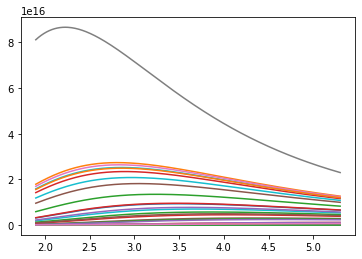

In [14]:
source = fits.getdata('io_scene_210518/io_volcs_210518.fits')
print(source.shape)
spec1 = fits.getdata('io_scene_210518/spectrum_1_210518.fits')
print(source.shape)
source1 = np.zeros((108,108,341))
for i in range(1,38):
    spec = fits.getdata('io_scene_210518/spectrum_'+str(i)+'_210518.fits')
    
    order = np.argsort(spec[:,0])
    lams = spec[order][:,0]
    spec = spec[order][:,1]
    plt.plot(np.linspace(1.9,5.3,341), spectres(np.linspace(1.9,5.3,341), lams, spec))
    source1[source == i,:] = spectres(np.linspace(1.9,5.3,341), lams, spec)

(108, 108, 341)


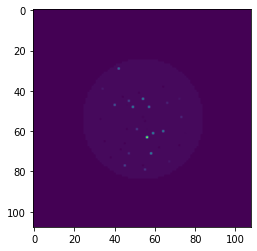

In [18]:
print(source1.shape)
source2 = np.array([source1[:,:,x] for x in range(341)])
plt.imshow(source2[10]**0.5)
plt.show()

In [19]:
def ft_convolve(psf,scene):
    print(scene.shape)
    FT_psf = np.array([np.fft.fft2(psf[i]) for i in range(len(psf))])
    FT_scene = np.array([np.fft.fft2(scene[i]) for i in range(len(scene))])
    
    FT_conv = FT_psf*FT_scene
    scene_conv = np.array([np.real(np.fft.ifftshift(np.fft.ifft2(FT_conv[i]))) for i in range(len(scene))])
    return(scene_conv)

[2.9, 4.15]


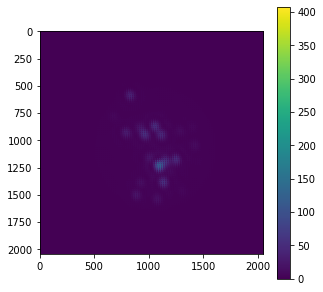

max counts = 407.67150276375736
median counts = 0.06113592612782724
mean counts = 1.4529126826646084
min counts = 8.11842824992743e-11
6.986006168524424
------------------------------
[2.0, 5.2]
2.0_5.2_prism.txt
(341, 108, 108)
using cube
making full raw image


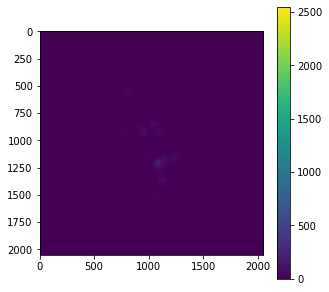

max counts = 2547.7431469510693
median counts = 0.11874729863403241
mean counts = 2.7032844729359002
min counts = -1.1434457591156358e-10
1.0893016974131267
------------------------------
[2.0, 4.0]
2.0_4.0_prism.txt
(341, 108, 108)
using cube
making full raw image


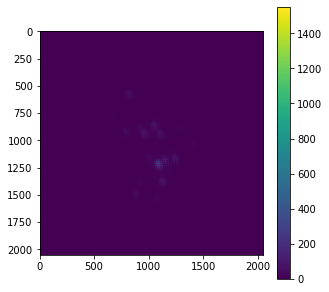

max counts = 1550.4096319944847
median counts = 0.054385262630618166
mean counts = 1.7877487849657545
min counts = -5.893288332221407e-11
3.1808112700780233
------------------------------
[3.1, 3.5]
3.1_3.5_prism.txt
(341, 108, 108)
using cube
making full raw image


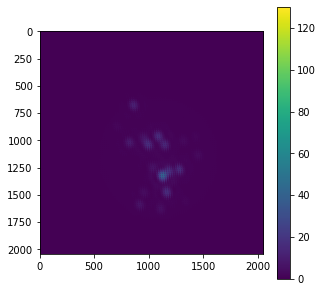

max counts = 129.982537187368
median counts = 0.016725112442288113
mean counts = 0.4408499430706626
min counts = 1.822137739542541e-11
28.617558113733928
------------------------------
[4.5, 5.2]
4.5_5.2_prism.txt
(341, 108, 108)
using cube
making full raw image


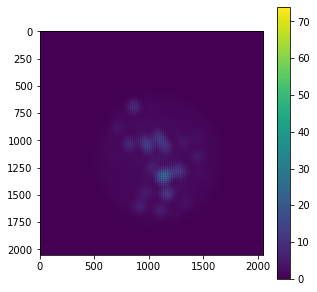

max counts = 73.93598048182461
median counts = 0.04777463639666801
mean counts = 0.7485580387018664
min counts = 7.832925430343265e-18
6.3451231996218365
------------------------------
[1.95, 2.45]
1.95_2.45_prism.txt
(341, 108, 108)
using cube
making full raw image


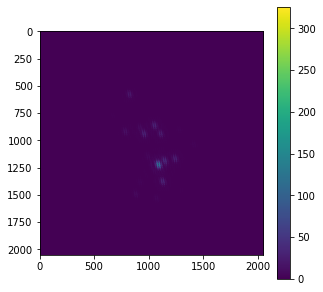

max counts = 325.7024704559759
median counts = 0.00859962039382851
mean counts = 0.3904409983623344
min counts = -2.589600950379921e-07
40.11343709627787
------------------------------


In [32]:
modes = [[2.9,4.15],[2.0,5.2],[2.0,4.0],[3.1,3.5],[4.5,5.2],[1.95,2.45]]
for wavs in modes:
    print(wavs)
    wav_min,wav_max = wavs
    rawfile = 'Io_asahi_disp_'+str(wav_min)+'_'+str(wav_max)+'_phot_s.fits'
    if os.path.isfile(rawfile)==False:
        arg_spaxel['min_wavelength'] = wav_min #minimum wavelength in microns
        arg_spaxel['max_wavelength'] = wav_max #maximum wavelength in microns

        lens = Lenslet(arg_spaxel)
        lens.get_shifts()
        lens.make_trace(phys=True,disp=True,verbose=True)

        nspax = arg_spaxel['no_spaxel']
        nlam = lens.trace.shape[0]

        keck_cube = np.zeros((nlam, nspax, nspax))
        mag1 = magn(lens.lmin)
        mag2 = magn(lens.lmax)

        psf_file = 'keck_psf_cube_'+str(lens.lmin)+'_'+str(lens.lmax)+'_n'+str(nlam)+'.fits'
        if os.path.isfile(psf_file)==False:
            for i, mag in enumerate(np.linspace(mag1, mag2, nlam)):
                W = DFT_matrix(1600, mag)
                A = pupil.pupil * np.exp(1.j * screen1)
                out = abs(W.dot(A).dot(W))**2
                out /= np.sum(out, axis=(0,1))
                keck_cube[i] = frebin(out, (108, 108))
            fits.writeto(psf_file,np.array(keck_cube),clobber=True)
        else: keck_cube = pyfits.getdata(psf_file)
        io_scene_conv = ft_convolve(keck_cube,source2)
        #io_scene_conv is in units of erg / micron / s / steradian (I think)
        #divide by distance to get to erg / micron / s / cm^2 / steradian
        io_scene_conv = io_scene_conv / (6.26e13)**2
        
        io_scene_conv_units = io_scene_conv*u.erg / u.cm**2 / u.micron / u.s


        vapor = 1 #PWV in mm
        airmass = 1 
        skybg = SkyBG(vapor,airmass)
        skytrans = SkyTrans(vapor,airmass)
        atmodisp = AtmoDispersion(90,20,600)

        telAO_emissivities = [0.4]
        telAO_temps = [285*u.K]
        scales_trans = [0.616]
        inst = InstTransEm(telAO_emissivities, telAO_temps, scales_trans)
        qe = QE(0.88) ##detector 6 is ~0.8, detector 8 is 0.88 -- testing "worst case" for saturation using detector 8


        filt = Filter(lmin=lens.lmin,lmax=lens.lmax,fkw='asahi')
        dit = 1 ###integration time in seconds

        ####organize all these and pass to focal_plane 
        args_new = {'Lenslet_object':lens,
                'SkyBG':skybg,
                'SkyTrans':skytrans,
                'InstTransEm':inst,
                'Filter':filt,
                'QE':qe}
        fp = FocalPlane(args_new)

        from time import time
        t1 = time()
        raw, bg_star_truth = fp.get_fp(dit*u.s,cube=io_scene_conv_units,return_full=True, bg_off=True)
        pyfits.writeto(rawfile,np.array(raw),clobber=True)
    else: raw = pyfits.getdata(rawfile)
    #rawfile = 'Astar_10pc_asahi_disp_'+str(wav_min)+'_'+str(wav_max)+'_e_s.fits'
    #pyfits.writeto(rawfile,np.array(raw*0.8),clobber=True)
    

    f = plt.figure(figsize=(5,5))
    plt.imshow(raw)
    plt.colorbar()
    plt.show()
    t2 = time()
    print('max counts = '+str(np.max(raw)))
    print('median counts = '+str(np.median(raw)))
    print('mean counts = '+str(np.mean(raw)))
    print('min counts = '+str(np.min(raw)))
    print((t2-t1)/60.0)
    print('------------------------------')
